# Temporal Analysis
---

In [1]:
import matplotlib.pyplot as plt

# font
plt.rcParams['font.sans-serif'] = ['Arial']
LABEL_FONT = {
    "fontsize": 12,
    "weight": "bold",
}    

# colors
BLUE = '#2878B5'
LIGHTBLUE = '#9AC9DB'
ORANGE = '#F8AC8C'
RED = '#C82423'
PINK = '#FF8884'
GREY = '#9E9E9E'
DEEPGREEN = '#32B897'
GREEN = '#96CCCB'

plt.rcParams['figure.dpi'] = 300

In [2]:
from analysis import Aggregator

# bins
agg = Aggregator()
SPEED_BIN = agg.SPEED_BIN
ACC_BIN = agg.ACC_BIN
DECEL_BIN = agg.BRAKE_DECEL_BIN
VSP_BIN = agg.VSP_BIN

import numpy as np
OpModeERs = np.load("./data/agg/OpModeERs.npy")

## 1 Date

In [3]:
import pickle
with open("./data/agg/agg_date.pkl", 'rb') as f:
    agg_date = pickle.load(f)

agg_date['brakeFrac'] = agg_date['brakeCount'] / agg_date['trajCount']
agg_date['brakeFreq'] = agg_date['brakeEventNum'] / agg_date['mileage']  # #/km
agg_date['brakeTimeMean'] = agg_date['brakeCount'] / agg_date['brakeEventNum']  # sec
agg_date['brakeDecelBinFrac'] = agg_date['brakeDecelBinCount'] / agg_date['brakeCount']
agg_date['OpModeFrac'] = agg_date['OpModeCount'] / agg_date['trajCount']
agg_date['PM10 ER Avg'] = agg_date['OpModeFrac'].apply(lambda x: sum(x * OpModeERs))  # g/hr
agg_date['Daily BWE'] = agg_date['PM10 ER Avg'] * agg_date['trajCount'] / 3600  # g
agg_date['PM10 EF Avg'] = agg_date['Daily BWE'] / agg_date['mileage'] * 1000  # mg/km/veh

### 1.1 Descriptive

In [4]:
agg_date['PM10 EF Avg'].min(), agg_date['PM10 EF Avg'].max(), agg_date['PM10 EF Avg'].mean(),

(24.396751843364125, 26.523352945279658, 25.623956995106607)

In [5]:
EF_weekday = agg_date.loc[list(set(agg_date.index) - set([4,5,11,12,18,19,25,26]))]['PM10 EF Avg'].mean()
EF_fri_sat = agg_date.loc[[4,5,11,12,18,19,25,26]]['PM10 EF Avg'].mean()
EF_fri_sat, EF_weekday, (EF_fri_sat-EF_weekday) / EF_weekday

(26.074402882196964, 25.460158490710118, 0.024125709653809533)

In [7]:
agg_date['Daily BWE'].mean()

14682.807809280575

### 1.2 Variations

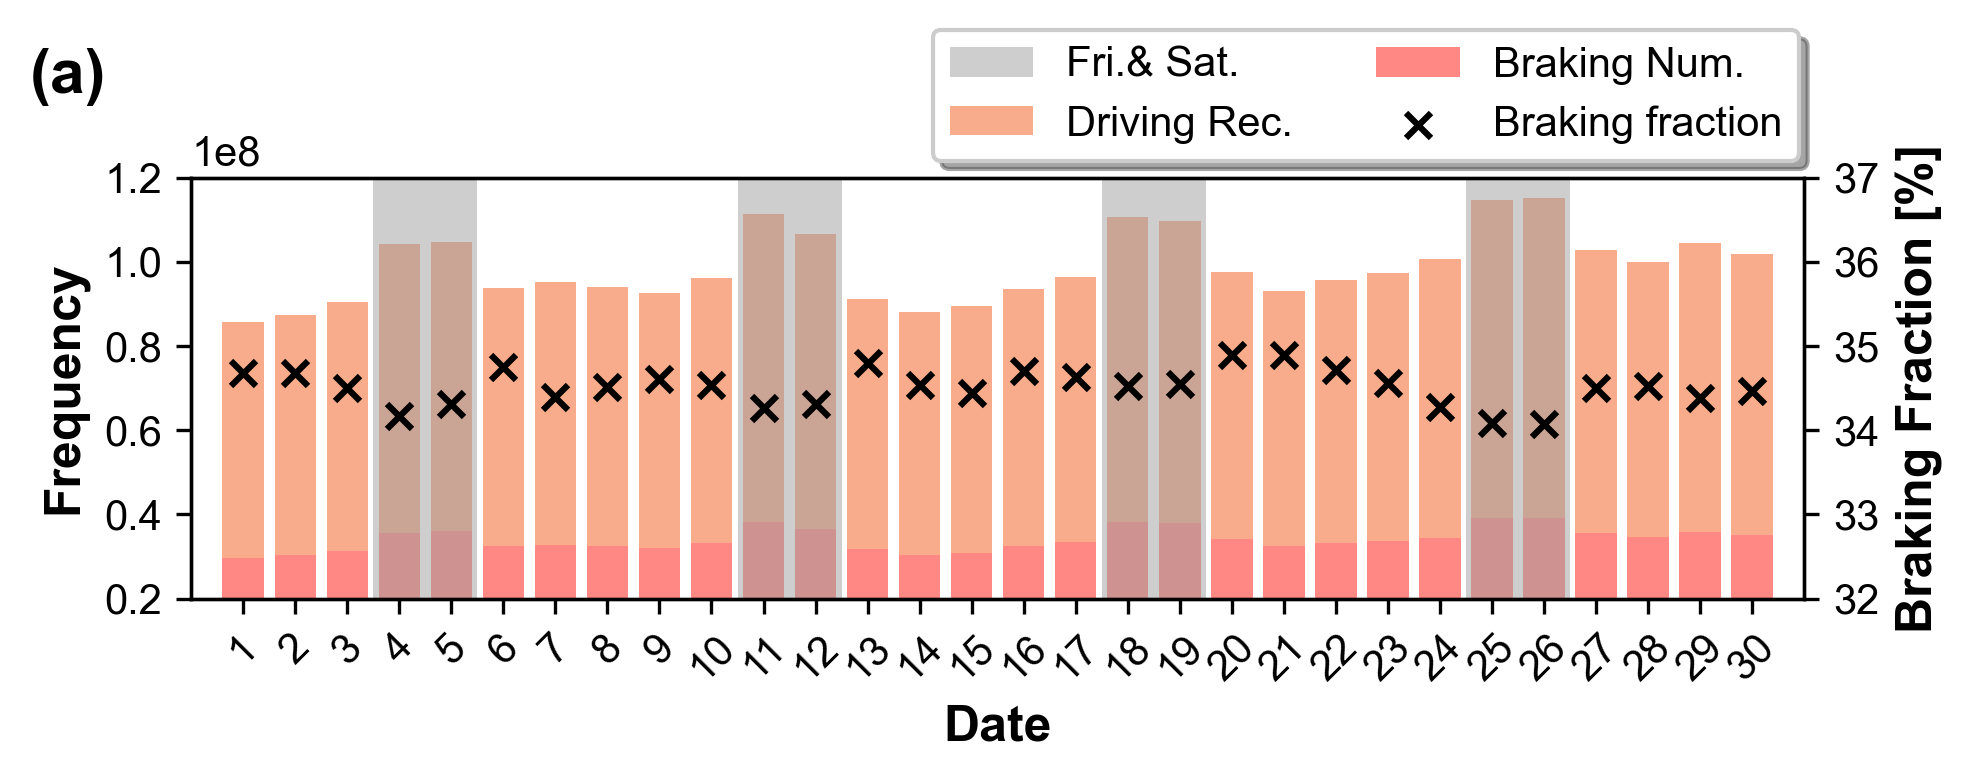

In [8]:
fig, ax = plt.subplots(1,1, figsize=(6.5,2.4), constrained_layout=True)

# count-bar
dates = np.arange(1,31)
ax.bar(dates, agg_date['trajCount'], color=ORANGE, label="Driving Rec.")
ax.bar(dates, agg_date['brakeCount'], color=PINK, label="Braking Num.")

# span
weekend= np.array([4, 11, 18, 25])
for id, fri in enumerate(weekend):
    if id == 0:
        ax.axvspan(fri-0.5, fri+1.5, facecolor=GREY, alpha=0.5, label="Fri.& Sat.")
    else:
        ax.axvspan(fri-0.5, fri+1.5, facecolor=GREY, alpha=0.5)

ax.set_xlim(0,31)
ax.set_ylim(0.2*10**8,1.2*10**8)
ax.set_xticks(dates)
ax.set_xticklabels(dates, rotation=45)

# frac-scatter
ax_ = ax.twinx()
ax_.scatter(dates, agg_date['brakeFrac']*100, color="k", marker="x", label="Braking fraction")
ax_.set_ylim(32, 37)

# labels
ax.text(-0.1, 1.2, "(a)", transform=ax.transAxes, fontdict=LABEL_FONT, fontsize=15)
ax.set_xlabel("Date", fontdict=LABEL_FONT)
ax.set_ylabel("Frequency", fontdict=LABEL_FONT)
ax_.set_ylabel("Braking Fraction [%]", fontdict=LABEL_FONT)

fig.legend(loc=1, bbox_to_anchor=(1.01,1.4), bbox_transform=ax.transAxes, ncol=2, shadow=True)
# 1.01,1.35
plt.show()

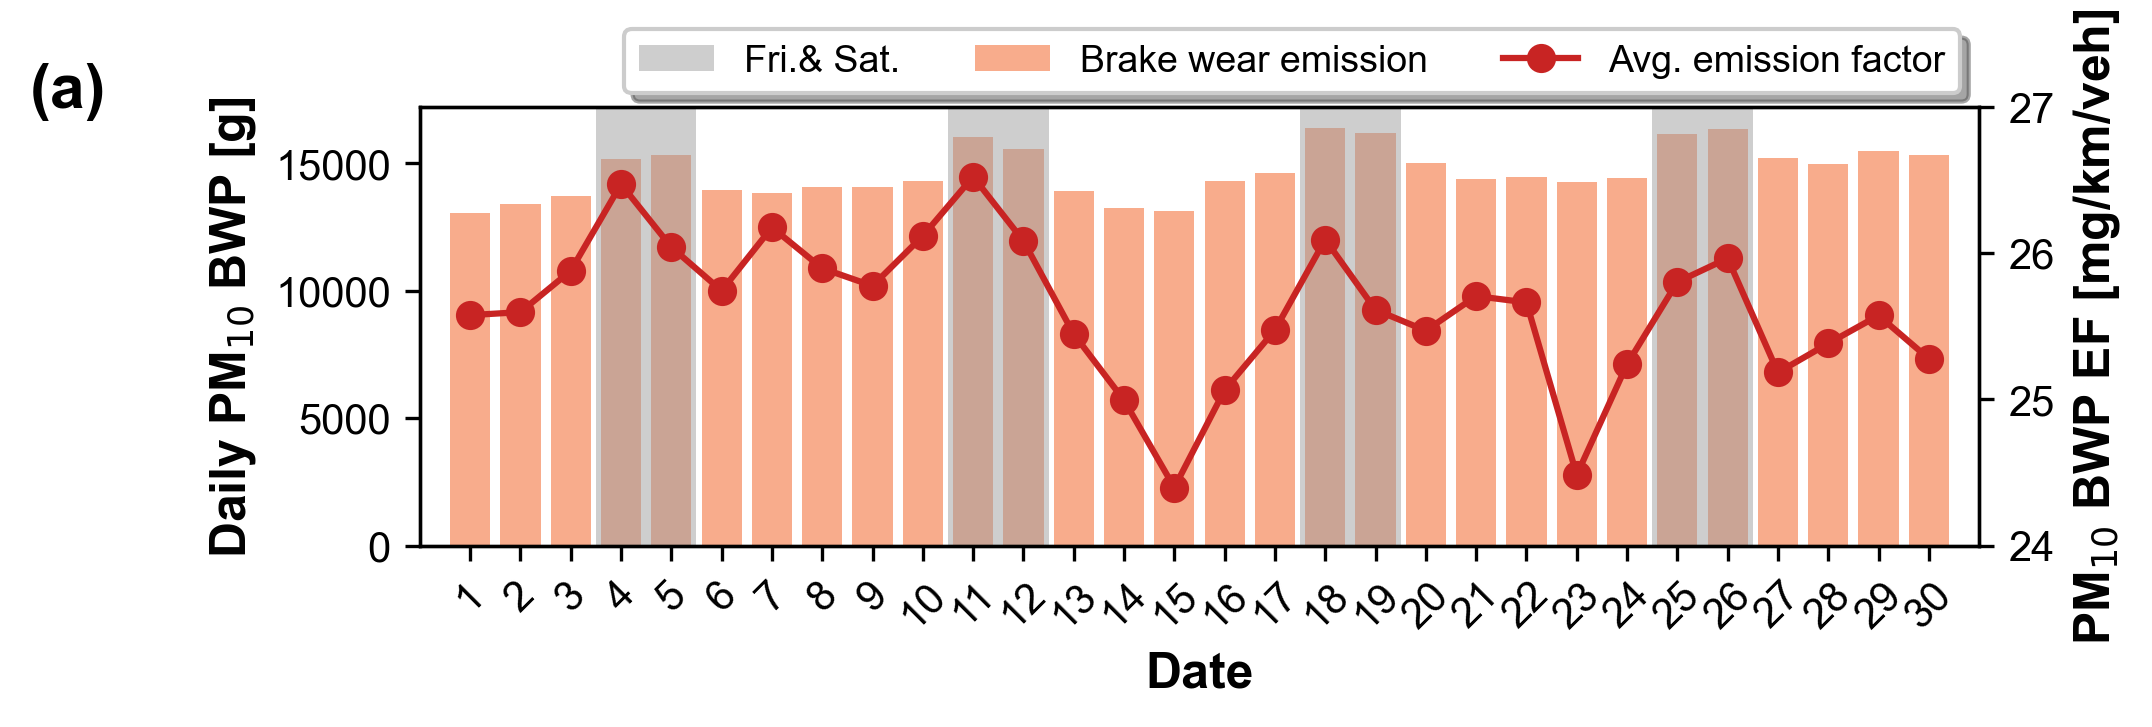

In [5]:
fig, ax = plt.subplots(1,1, figsize=(7,2.2), constrained_layout=True)

# BWE
dates = np.arange(1,31)
ax.bar(dates, agg_date['Daily BWE'], color=ORANGE, label="Brake wear emission")
ax.set_xlim(0,31)
ax.set_xticks(dates)
ax.set_xticklabels(dates, rotation=45)
ax.set_xlabel("Date", fontdict=LABEL_FONT)
ax.set_ylabel("Daily PM$_{10}$ BWP [g]", fontdict=LABEL_FONT)

# span
weekend= np.array([4, 11, 18, 25])
for id, fri in enumerate(weekend):
    if id == 0:
        ax.axvspan(fri-0.5, fri+1.5, facecolor=GREY, alpha=0.5, label="Fri.& Sat.")
    else:
        ax.axvspan(fri-0.5, fri+1.5, facecolor=GREY, alpha=0.5)

# plot
ax_ = ax.twinx()
ax_.plot(dates, agg_date['PM10 EF Avg'], color=RED, marker="o", label="Avg. emission factor")
ax_.set_ylabel("PM$_{10}$ BWP EF [mg/km/veh]", fontdict=LABEL_FONT)
ax_.set_ylim(24, 27)

# labels
ax.text(-0.25, 1.0, "(a)", transform=ax.transAxes, fontdict=LABEL_FONT, fontsize=15)
fig.legend(loc=1, bbox_to_anchor=(1,1.22), bbox_transform=ax.transAxes, ncol=3, shadow=True, fontsize=9)
plt.show()

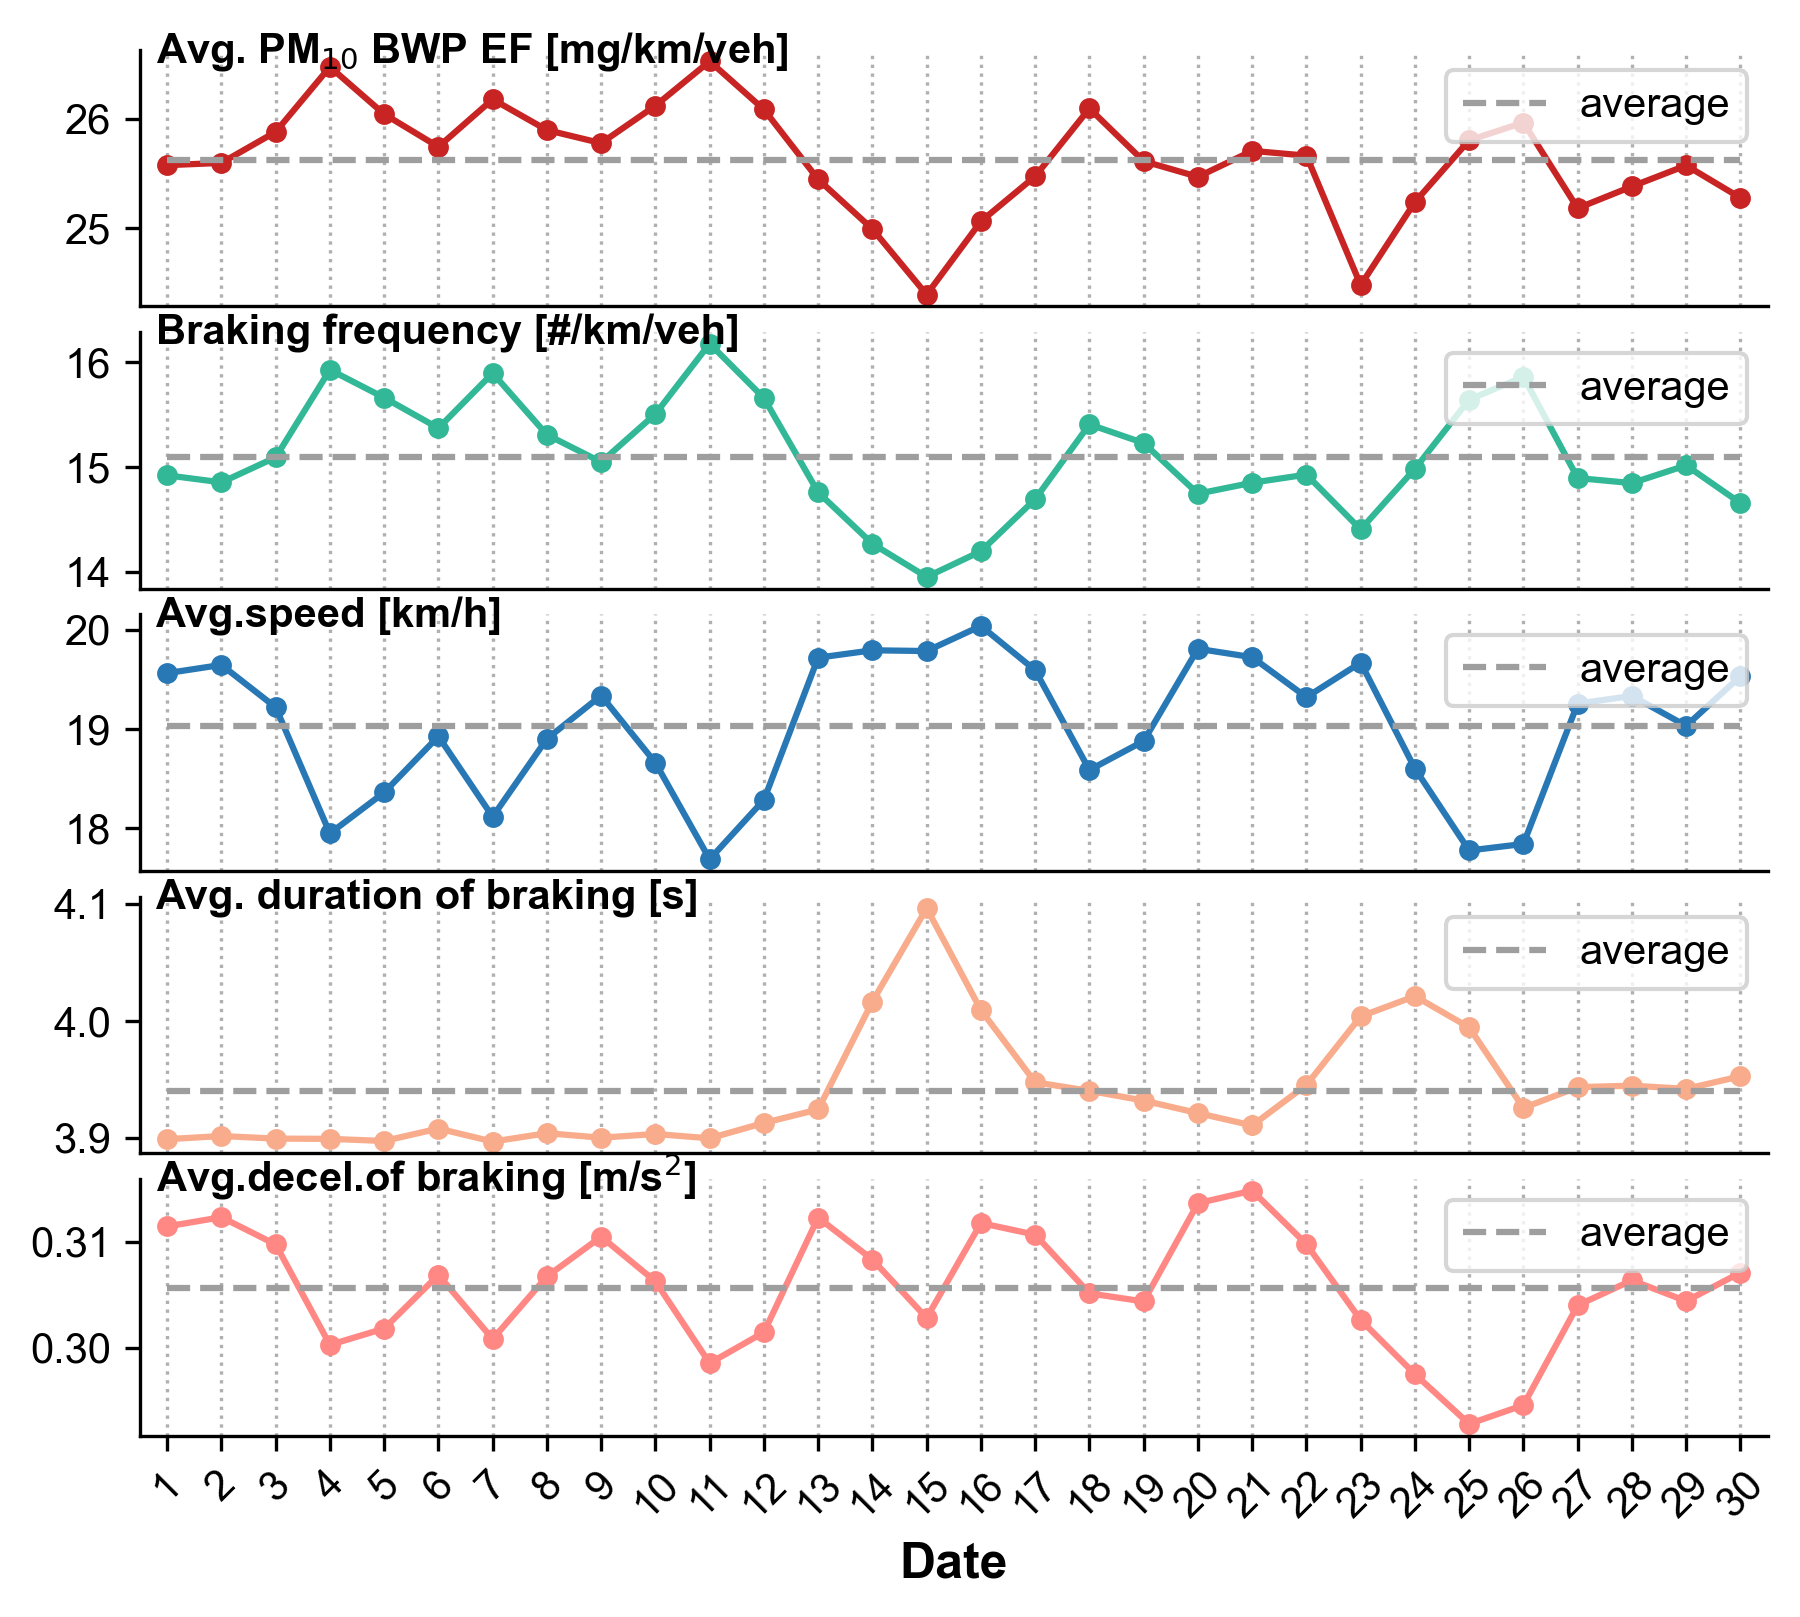

In [6]:
fig, ax = plt.subplots(5,1,figsize=(7,6))
ax = ax.flatten()

dates = np.arange(1,31,1)
agg_date_speed = agg_date.apply(lambda x: sum(x['speedBinCount'] / x['trajCount'] * SPEED_BIN[:-1]), axis=1)
agg_date_freq = agg_date['brakeFreq']
agg_date_time = agg_date['brakeTimeMean']
agg_date_decel = agg_date.apply(lambda x: sum(x['brakeDecelBinCount'] / x['trajCount'] * DECEL_BIN[:-1]), axis=1)

ax[0].plot(dates, agg_date['PM10 EF Avg'], color=RED, marker='o', markersize=4)
ax[0].hlines(agg_date['PM10 EF Avg'].mean(), 1, 30, color=GREY, linestyle='--', label='average')
ax[0].text(0.01, 0.95, "Avg. PM$_{10}$ BWP EF [mg/km/veh]", transform=ax[0].transAxes, fontdict=LABEL_FONT, fontsize=10, ha='left')

ax[1].plot(dates, agg_date_freq, color=DEEPGREEN, marker='o', markersize=4)
ax[1].hlines(agg_date_freq.mean(), 1, 30, color=GREY, linestyle='--', label='average')
ax[1].text(0.01, 0.95, "Braking frequency [#/km/veh]", transform=ax[1].transAxes, fontdict=LABEL_FONT, fontsize=10, ha='left')

ax[2].plot(dates, agg_date_speed, color=BLUE, marker='o', markersize=4)
ax[2].hlines(agg_date_speed.mean(), 1, 30, color=GREY, linestyle='--', label='average')
ax[2].text(0.01, 0.95, "Avg.speed [km/h]", transform=ax[2].transAxes, fontdict=LABEL_FONT, fontsize=10, ha='left')

ax[3].plot(dates, agg_date_time, color=ORANGE, marker='o', markersize=4)
ax[3].hlines(agg_date_time.mean(), 1, 30, color=GREY, linestyle='--', label='average')
ax[3].text(0.01, 0.95, "Avg. duration of braking [s]", transform=ax[3].transAxes, fontdict=LABEL_FONT, fontsize=10, ha='left')

ax[4].plot(dates, agg_date_decel, color=PINK, marker='o', markersize=4)
ax[4].hlines(agg_date_decel.mean(), 1, 30, color=GREY, linestyle='--', label='average')
ax[4].text(0.01, 0.95, "Avg.decel.of braking [m/s$^2$]", transform=ax[4].transAxes, fontdict=LABEL_FONT, fontsize=10, ha='left')

# ticks
for ax_ in [ax[0], ax[1], ax[2], ax[3]]:
    ax_.set_xticks(dates, [])
    ax_.tick_params(bottom=False)

ax[4].set_xlabel("Date", fontdict=LABEL_FONT)
ax[4].set_xticks(dates)
ax[4].set_xticklabels(dates, rotation=45)

# axis
for ax_ in ax:
    ax_.set_xlim(0.5, 30.5)
    ax_.legend(loc=1)
    ax_.grid(axis='x', linestyle=":")
    ax_.spines['top'].set_visible(False)
    ax_.spines['right'].set_visible(False)
    ax_.yaxis.set_label_position('right')
plt.subplots_adjust(hspace=0.1)
plt.show()

## 2 Hour

### Descriptive

In [7]:
with open("./data/agg/agg_hour.pkl", 'rb') as f:
    agg_hour = pickle.load(f)
    
agg_hour['brakeFrac'] = agg_hour['brakeCount'] / agg_hour['trajCount']
agg_hour['brakeFreq'] = agg_hour['brakeEventNum'] / agg_hour['mileage']  # #/km
agg_hour['brakeTimeMean'] = agg_hour['brakeCount'] / agg_hour['brakeEventNum']  # sec
agg_hour['brakeDecelBinFrac'] = agg_hour['brakeDecelBinCount'] / agg_hour['brakeCount']
agg_hour['OpModeFrac'] = agg_hour['OpModeCount'] / agg_hour['trajCount']
agg_hour['PM10 ER Avg'] = agg_hour['OpModeFrac'].apply(lambda x: sum(x * OpModeERs))
agg_hour['Hourly BWE'] = agg_hour['PM10 ER Avg'] * agg_hour['trajCount'] / 3600 / 30
agg_hour['PM10 EF Avg'] = agg_hour['Hourly BWE'] / agg_hour['mileage'] * 30 * 1000  # mg/km/veh

In [12]:
agg_hour.loc[[0,1,2,3,4,5,6]]['PM10 EF Avg'].mean()

22.32765672038799

In [13]:
agg_hour.loc[[7,8,9,10,11,12,13,14,15,16,17,18]]['PM10 EF Avg'].mean()

26.331602493321697

In [14]:
offpeak = agg_hour.loc[[0,1,2,3,4,5,6,7,19,20,21,22,23]]['PM10 EF Avg'].mean()
peak = agg_hour.loc[[8,9,10,11,12,13,14,15,16,17,18]]['PM10 EF Avg'].mean()
(peak - offpeak) / offpeak

0.13255517680851592

### Variations

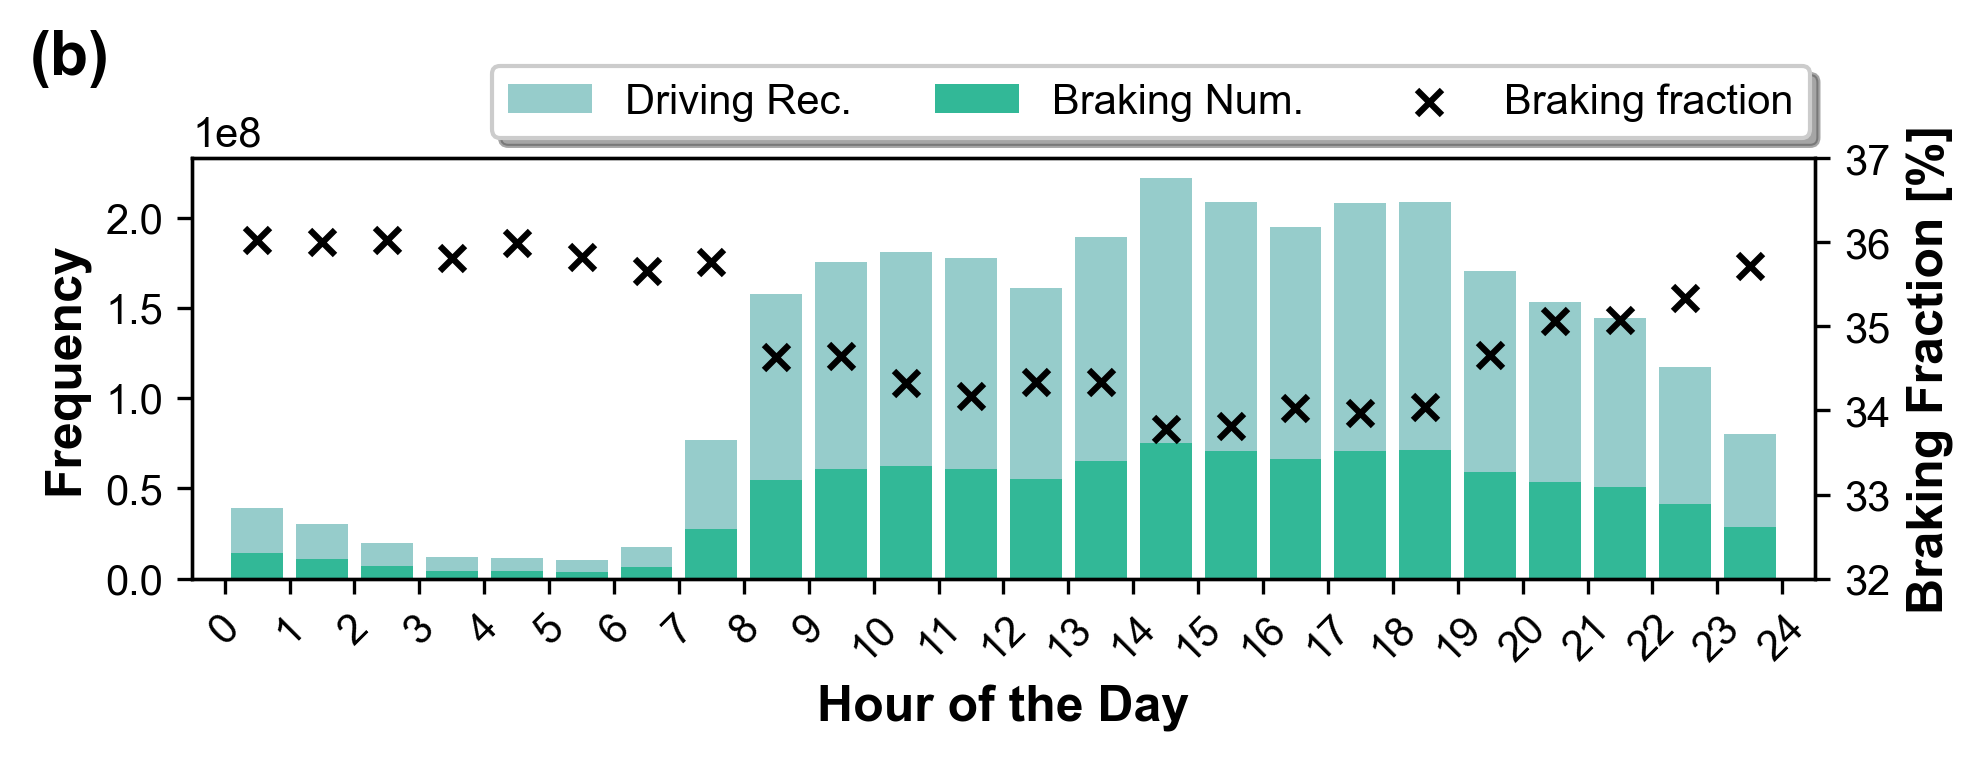

In [15]:
fig, ax = plt.subplots(1,1, figsize=(6.5,2.4), constrained_layout=True)


# count-bar
hours = np.arange(0,24)
ax.bar(hours+0.5, agg_hour['trajCount'], color=GREEN, label="Driving Rec.")
ax.bar(hours+0.5, agg_hour['brakeCount'], color=DEEPGREEN, label="Braking Num.")

ax.set_xlim(-0.5,24.5)
# ax.set_ylim(0,1.55*10**8)
ax.set_xticks(np.arange(0, 25))
ax.set_xticklabels(np.arange(0, 25), rotation=45)

# frac-scatter
ax_ = ax.twinx()
ax_.scatter(hours+0.5, agg_hour['brakeFrac']*100, color="k", marker="x", label="Braking fraction")
ax_.set_ylim(32, 37)

# labels
ax.text(-0.1, 1.2, "(b)", transform=ax.transAxes, fontdict=LABEL_FONT, fontsize=15)
ax.set_xlabel("Hour of the Day", fontdict=LABEL_FONT)
ax.set_ylabel("Frequency", fontdict=LABEL_FONT)
ax_.set_ylabel("Braking Fraction [%]", fontdict=LABEL_FONT)

fig.legend(loc=1, bbox_to_anchor=(1.01,1.27), bbox_transform=ax.transAxes, ncol=3, shadow=True)
plt.show()

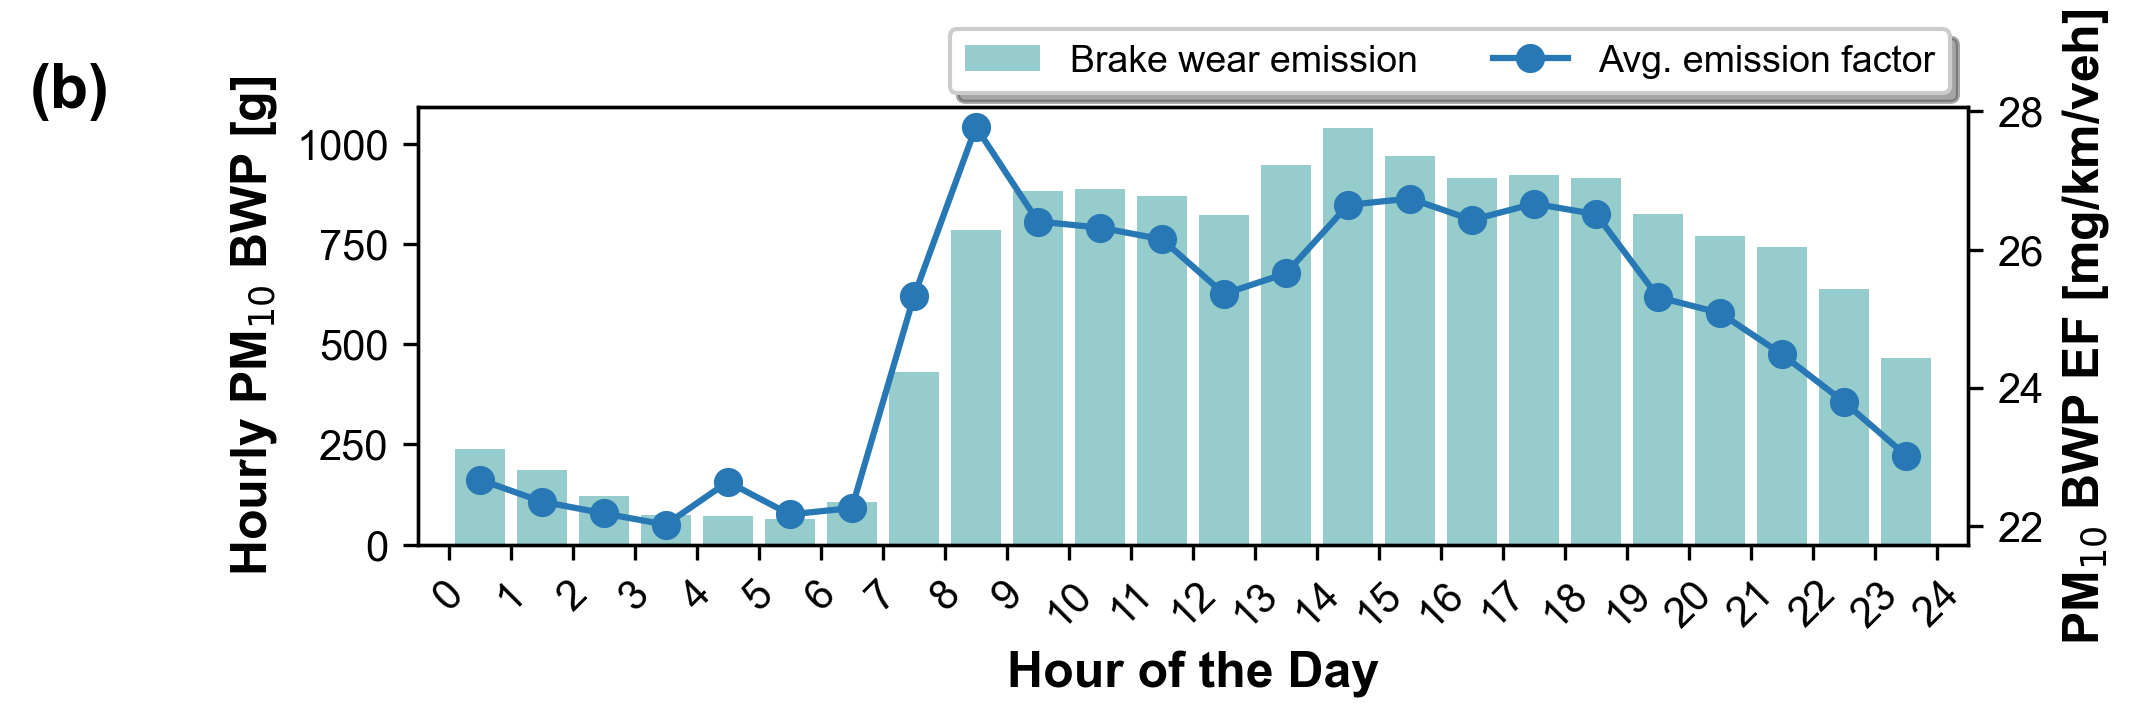

In [8]:
fig, ax = plt.subplots(1,1, figsize=(7,2.2), constrained_layout=True)

# hourly BWE
hours = np.arange(0,24)
ax.bar(hours+0.5, agg_hour['Hourly BWE'], color=GREEN, label="Brake wear emission")
ax.set_xlim(-0.5,24.5)
ax.set_xticks(np.arange(0, 25))
ax.set_xticklabels(np.arange(0, 25), rotation=45)
ax.set_xlabel("Hour of the Day", fontdict=LABEL_FONT)
ax.set_ylabel("Hourly PM$_{10}$ BWP [g]", fontdict=LABEL_FONT)


# amount plot
ax_ = ax.twinx()
ax_.plot(hours+0.5, agg_hour['PM10 EF Avg'], color=BLUE, marker="o", label="Avg. emission factor")
ax_.set_ylabel("PM$_{10}$ BWP EF [mg/km/veh]", fontdict=LABEL_FONT)
# ax_.set_ylim(33.5, 40)
ax.text(-0.25, 1, "(b)", transform=ax.transAxes, fontdict=LABEL_FONT, fontsize=15)
fig.legend(loc=1, bbox_to_anchor=(1,1.22), bbox_transform=ax.transAxes, ncol=2, shadow=True, fontsize=9)
# fig.legend(loc=1, bbox_to_anchor=(1.22,0.7), bbox_transform=ax.transAxes)
plt.show()

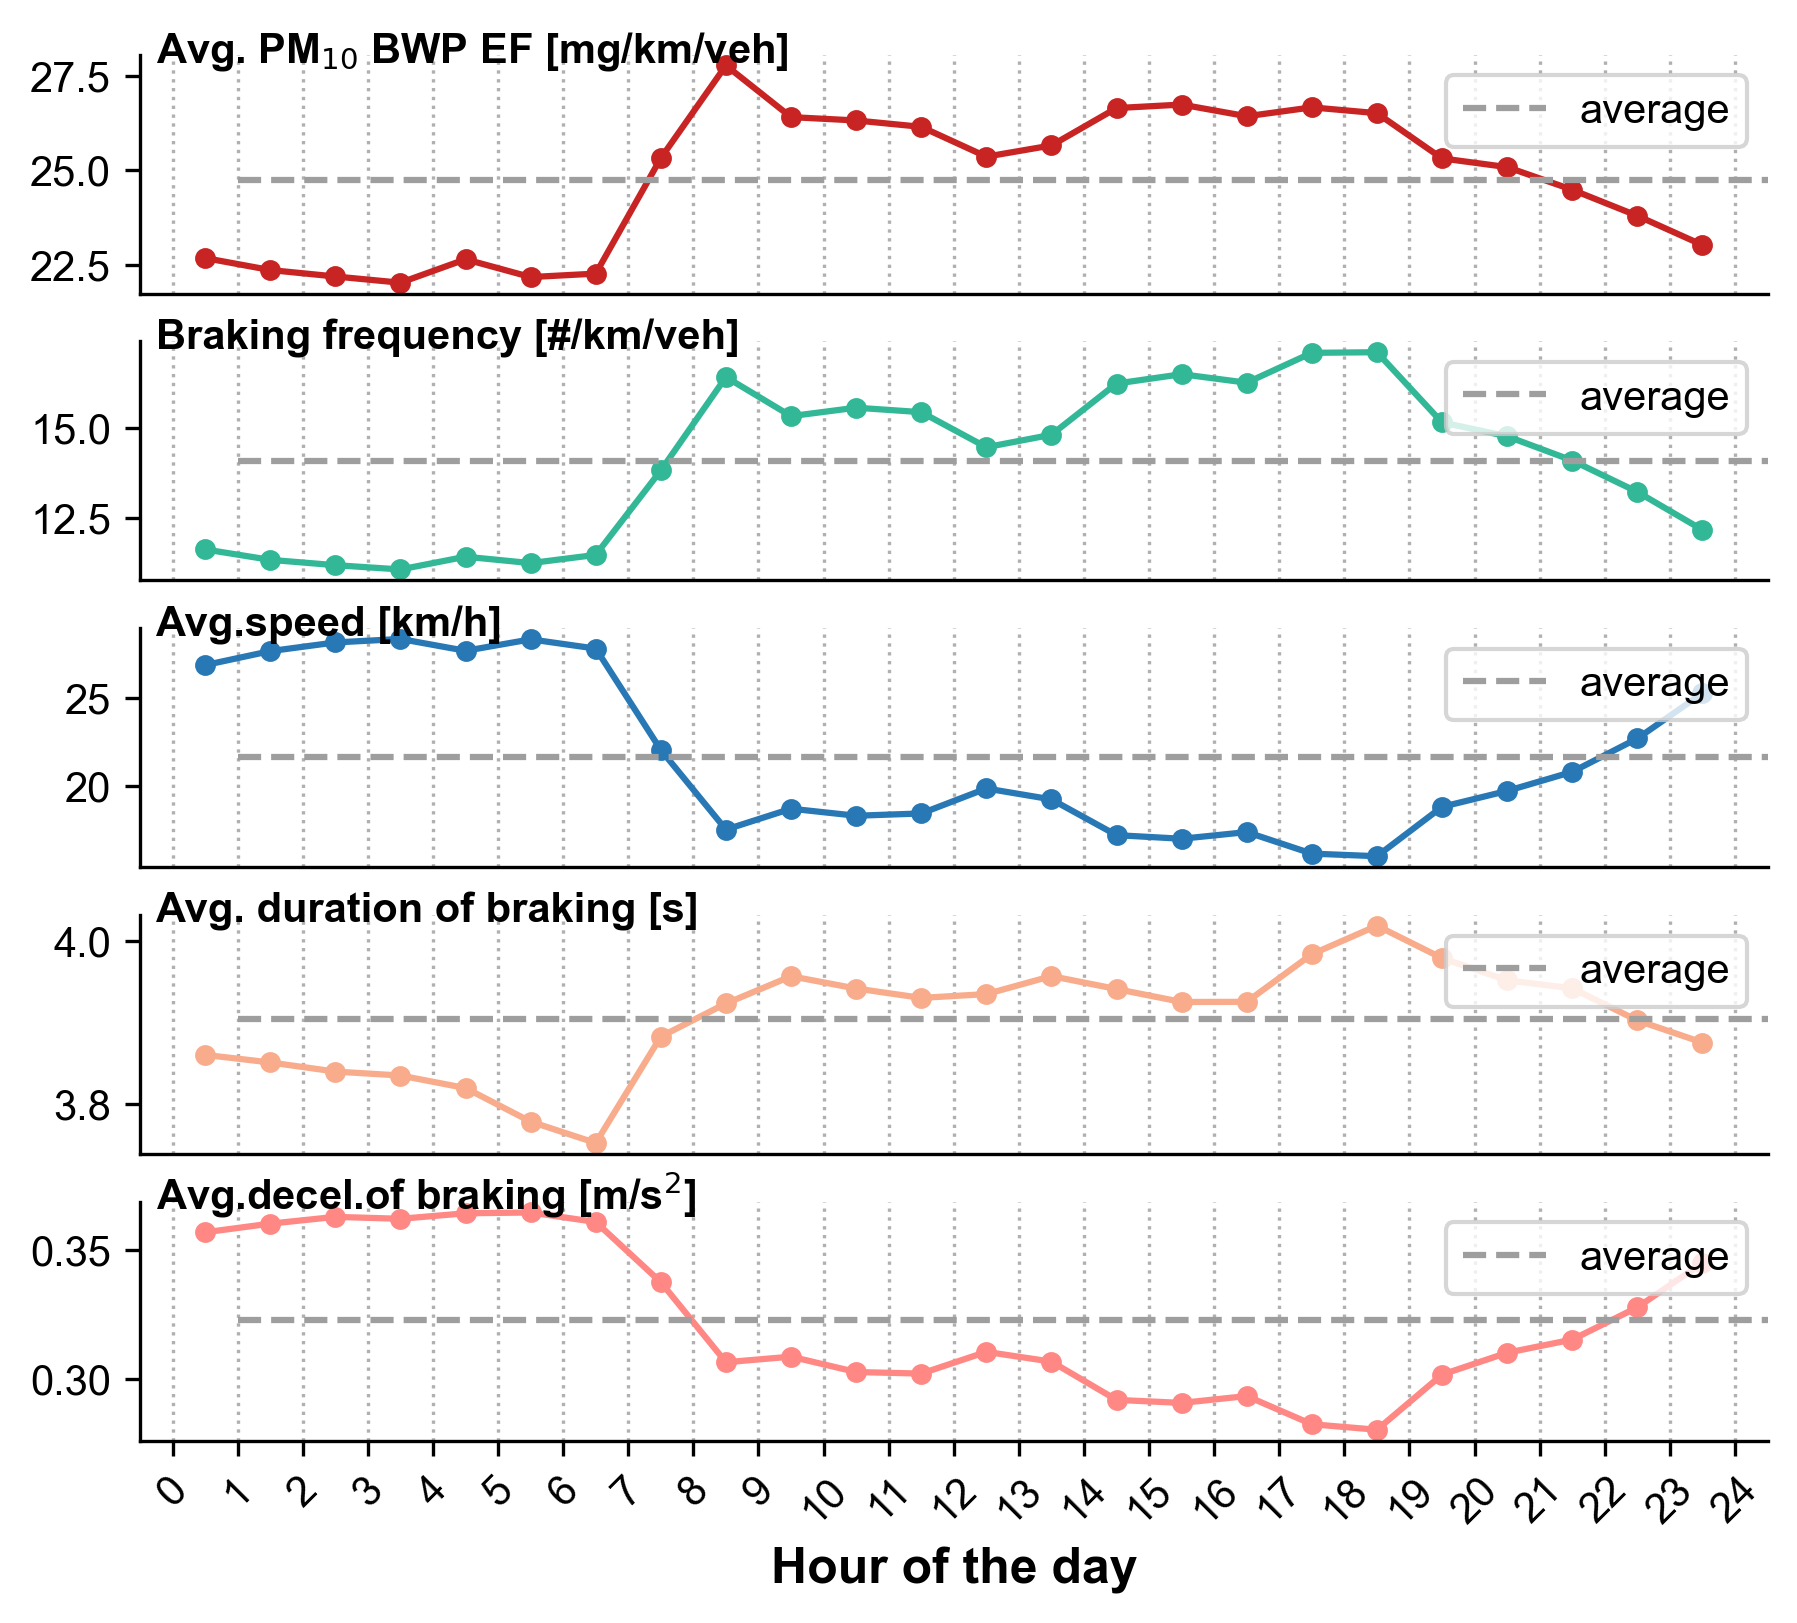

In [9]:
fig, ax = plt.subplots(5,1,figsize=(7,6))
ax = ax.flatten()

hours = np.arange(0,24,1)
agg_hour_speed = agg_hour.apply(lambda x: sum(x['speedBinCount'] / x['trajCount'] * SPEED_BIN[:-1]), axis=1)
agg_hour_freq = agg_hour['brakeFreq']
agg_hour_time = agg_hour['brakeTimeMean']
agg_hour_decel = agg_hour.apply(lambda x: sum(x['brakeDecelBinCount'] / x['trajCount'] * DECEL_BIN[:-1]), axis=1)

ax[0].plot(hours+0.5, agg_hour['PM10 EF Avg'], color=RED, marker='o', markersize=4)
ax[0].hlines(agg_hour['PM10 EF Avg'].mean(), 1, 30, color=GREY, linestyle='--', label="average")
ax[0].text(0.01, 0.97, "Avg. PM$_{10}$ BWP EF [mg/km/veh]", transform=ax[0].transAxes, fontdict=LABEL_FONT, fontsize=10, ha='left')

ax[1].plot(hours+0.5, agg_hour_freq, color=DEEPGREEN, marker='o', markersize=4)
ax[1].hlines(agg_hour_freq.mean(), 1, 30, color=GREY, linestyle='--', label="average")
ax[1].text(0.01, 0.97, "Braking frequency [#/km/veh]", transform=ax[1].transAxes, fontdict=LABEL_FONT, fontsize=10, ha='left')

ax[2].plot(hours+0.5, agg_hour_speed, color=BLUE, marker='o', markersize=4)
ax[2].hlines(agg_hour_speed.mean(), 1, 30, color=GREY, linestyle='--', label="average")
ax[2].text(0.01, 0.97, "Avg.speed [km/h]", transform=ax[2].transAxes, fontdict=LABEL_FONT, fontsize=10, ha='left')

ax[3].plot(hours+0.5, agg_hour_time, color=ORANGE, marker='o', markersize=4)
ax[3].hlines(agg_hour_time.mean(), 1, 30, color=GREY, linestyle='--', label="average")
ax[3].text(0.01, 0.97, "Avg. duration of braking [s]", transform=ax[3].transAxes, fontdict=LABEL_FONT, fontsize=10, ha='left')

ax[4].plot(hours+0.5, agg_hour_decel, color=PINK, marker='o', markersize=4)
ax[4].hlines(agg_hour_decel.mean(), 1, 30, color=GREY, linestyle='--', label="average")
ax[4].text(0.01, 0.97, "Avg.decel.of braking [m/s$^2$]", transform=ax[4].transAxes, fontdict=LABEL_FONT, fontsize=10, ha='left')

# ticks
for ax_ in [ax[0], ax[1], ax[2], ax[3]]:
    ax_.set_xticks(hours, [])
    ax_.tick_params(bottom=False)

ax[4].set_xlabel("Hour of the day", fontdict=LABEL_FONT)
ax[4].set_xticks(np.arange(0, 25))
ax[4].set_xticklabels(np.arange(0, 25), rotation=45)

# axis
for ax_ in ax:
    ax_.set_xlim(-0.5,24.5)
    ax_.set_xticks(np.arange(0, 25))
    ax_.legend(loc=1)
    ax_.grid(axis='x', linestyle=":")
    ax_.spines['top'].set_visible(False)
    ax_.spines['right'].set_visible(False)
    ax_.yaxis.set_label_position('right')
plt.subplots_adjust(hspace=0.2)
plt.show()